# Data Science Case Study | January 2021

## Problem Definition

The case study involves around the analysis and exploration of anomymous battery data. We will use this notebook to perform data exploration, find out pattens and relations, and define new attributes. In the second part, we will define a use-case for prediction of SOC based on the input features aggregated hourly. <br>

The dataset consists of multiple folders, with each folders containing time-series raw data. The assumption is that each folder represent different batteries. For the purpose of simplicity, we will use a single battery data which has the longest running time and the largest data volume for our exploration and modelling.

### Load the required libraries

In [2]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)

In [3]:
# Importing all the dependencies required for this Notebook
%matplotlib inline
from glob import glob # pathname pattern expansion
import joblib # serialization
from scipy import stats # Statistics package
import numpy as np # Linear Algebra
import pandas as pd # Data Wrangling
import matplotlib.pyplot as plt # Plotting 
import seaborn as sns # Plotting
sns.set()
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
# Libraries specific to machine learning
from sklearn.model_selection import train_test_split # Split the dataset into train and test
from sklearn.model_selection import cross_val_score # Cross-validation score
from sklearn.preprocessing import StandardScaler # Standardization function
from sklearn.model_selection import RandomizedSearchCV, KFold # Cross-Validation and Parameter tuning
from sklearn.dummy import DummyRegressor # Dummy model for baseline scoring
from sklearn.metrics import r2_score, mean_squared_error # Evaluation metric for our use case
from sklearn.linear_model import LinearRegression # Linear regression model
from sklearn.svm import SVR # Support Vector Machines regression model
from sklearn.tree import DecisionTreeRegressor # CART model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # Tree Ensembles
from xgboost import XGBRegressor # Extreme Gradient Boostinge
from sklearn import clone # Clone function

### Load the battery data into a combined dataframe

In [5]:
# Load the data
df = pd.concat(map(pd.read_csv, glob('data/*.csv')))

# 'Change 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], unit='ns')

# Sort by timestamps
df = df.set_index('time')
df = df.sort_index()

df.head()

,I,V,T_max,T_min,SOC
time,,,,,
2017-03-28 12:52:00,0.0,0.0,-273.15,-273.15,0.0
2017-03-28 12:53:00,0.0,0.0,-273.15,-273.15,0.0
2017-03-28 12:54:00,0.0,0.0,-273.15,-273.15,0.0
2017-03-28 12:55:00,0.0,0.0,-273.15,-273.15,0.0
2017-03-28 12:56:00,0.0,0.0,-273.15,-273.15,0.0


### Descriptive Statistics

In [6]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Last Value'] = df.iloc[-1].values 

    return summary

display(df.describe().transpose())
summary(df)

,count,mean,std,min,25%,50%,75%,max
I,1266034.0,0.031784,20.568198,-559.195,-12.333,-0.419,-0.390,118.517
V,1266034.0,52.456523,2.428655,0.000,51.453,52.336,53.472,2229.579
T_max,1266034.0,21.234931,8.466169,-273.150,14.650,20.550,28.150,854.350
T_min,1266034.0,19.887628,8.279918,-273.150,13.550,19.150,26.850,36.850
SOC,1266034.0,57.746000,32.855023,0.000,24.000,53.000,98.000,100.000


Dataset Shape: (1266034, 5)


,Name,dtypes,Missing,Uniques,First Value,Last Value
0,I,float64,0,111479,0.00,-0.445
1,V,float64,0,12193,0.00,51.609
2,T_max,float64,0,362,-273.15,11.850
3,T_min,float64,0,333,-273.15,10.650
4,SOC,float64,0,101,0.00,23.000


Summary:
* No missing values.
* I, V, T_max and T_min have outliers.
* Per second sampling.
* 1.26 million observations.
* Time series is not continious (some gaps in periods).

#### Removing outliers below and above the 25th and 75th percentile respectively.

In [7]:
Q1 = df.quantile(0.25) #25th percentile
Q3 = df.quantile(0.75) #75th percentile
IQR = Q3 - Q1 #Inter-quartile range.

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

### Data Exploration

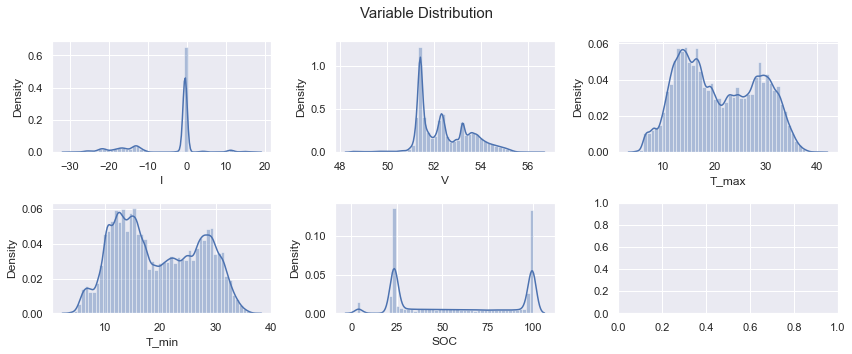

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12,5))
plt.suptitle('Variable Distribution', fontsize=15)
plt.subplots_adjust(hspace = 0.2)
for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//3,i%3])
plt.tight_layout()

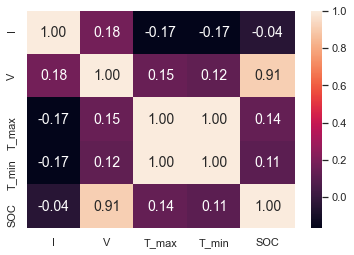

In [9]:
# Correlation plot
sns.heatmap(data=df.corr(), square=False, annot=True, annot_kws={'fontsize': 14}, fmt=".2f");

* Voltage is highly correlated with SOC.
* T_max and T_min are redundant. We can use the mean of both.
* Temperature and SOC exhibits bi-modal distributions.

Text(0.5, 1.0, 'Single Charge / Discharge cycle between 27th June and 28th June, 2018')

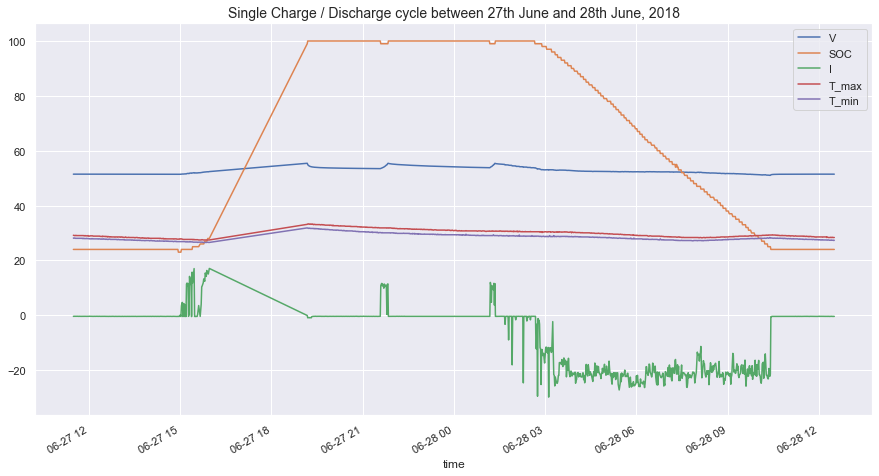

In [10]:
df[['V','SOC','I','T_max','T_min']].loc['2018-06-27 11:30:00':'2018-06-28 12:30:00'].plot(figsize=(15,8))
plt.title('Single Charge / Discharge cycle between 27th June and 28th June, 2018', size=14)

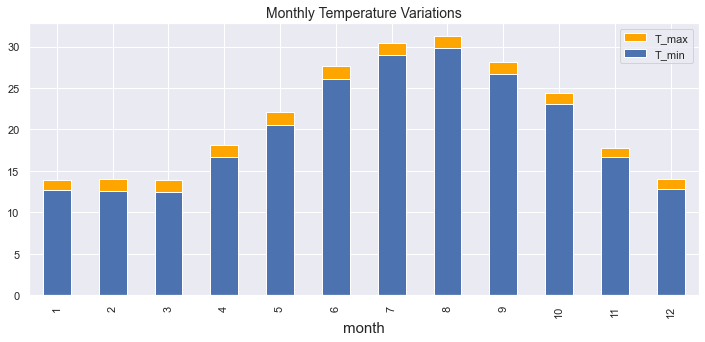

In [11]:
df.groupby(df.index.month)['T_max'].mean().plot(kind='bar', color='orange', legend=True)
df.groupby(df.index.month)['T_min'].mean().plot(kind='bar', legend=True, figsize=(12,5))
plt.title('Monthly Temperature Variations', size=14)
plt.xlabel('month', fontsize=15);

Battery temperature variations in relation to outside temperature in summer and winter months.

### Creating new attributes and data pre-processing

We create new attributes like the average temperature, the energy consumption per hour (watt-hour) and the battery capacity (amp-hour). We perform some basic processing steps like differentiating the train and validation set, scale the feature matrix and build a dummy regression model for baseline evaluation.

In [12]:
# Hourly aggregation
df_h = df.resample('60min').mean()
df_h = df_h.dropna(how='all',axis=0)

# Create new features
df_h['T_avg'] = (df_h['T_max'] + df_h['T_min']) / 2 # Average temperature
df_h['E'] = df_h['V'] * df_h['I'] # Energy 
df_h['Q'] = df_h['E'] / df_h['V'] # Capacity 

# Drop the redundant columns
df_h = df_h.drop(['T_max', 'T_min'], axis=1)

In [13]:
# Divide the data into features and target
X = df_h.drop(['SOC'], axis=1)
y = df_h['SOC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [14]:
# Normalize train and test set
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### SOC Prediction - Model selection and Evaluation

In [15]:
# Baseline Model (Dummy Regressor)

base = DummyRegressor(strategy='mean')
base.fit(X_train, y_train)

print("RMSE for Baseline model: ", np.sqrt(mean_squared_error(y_test, base.predict(X_test))))
print("R2 for Baseline model: ", r2_score(y_test, base.predict(X_test)))

RMSE for Baseline model:  33.336659073352656
R2 for Baseline model:  -5.1407769250388924e-05


The baseline model has an RMSE value of 32. 

In [16]:
# Spot checking various regression models
models = []

models.append(("Linear Regression", LinearRegression()))
models.append(("Support Vector Machines", SVR(C=100)))
models.append(("Decision Tree", DecisionTreeRegressor()))
models.append(("Random Forest", RandomForestRegressor()))
models.append(("Gradient Boosting", GradientBoostingRegressor()))
models.append(("Extreme Gradient Boosting", XGBRegressor()))

results = []
names = []
for name, model in models:
    result = cross_val_score(model, X_train, y_train,  cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
    names.append(name)
    results.append(np.abs(result))

for i in range(len(names)):
    print(names[i], results[i].mean())

Linear Regression 10.994821707453447
Support Vector Machines 5.284031926057986
Decision Tree 4.2740345025486715
Random Forest 3.277373069226519
Gradient Boosting 4.042749535599251
Extreme Gradient Boosting 4.038161070429964


The Random Forest model seems to have the lowest error. We will use this as our final model. As the next step we will tune the parameters (especially max depth) to prevent the model from overfitting.

In [17]:
### Parameter Tuning Random Forest Regression Model ###

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 8, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


cv = KFold(n_splits=5, shuffle=True, random_state=0)

rfm = RandomForestRegressor()
grid_rf = RandomizedSearchCV(rfm, param_distributions=parameters, scoring='neg_root_mean_squared_error', cv=cv,
                       return_train_score=True, n_iter = 25, n_jobs=-1, random_state=20)

grid_rf.fit(X_train, y_train)

print("Best parameters found: ", grid_rf.best_params_)
print("Lowest RMSE found: ", np.abs(grid_rf.best_score_))

Best parameters found:  {'n_estimators': 455, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
Lowest RMSE found:  3.5870494953993406


In [18]:
# Clone the model with the best parameters
model_rf = clone(grid_rf.best_estimator_)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
y_pred_train = model_rf.predict(X_train)

print("R2 for test set: ", r2_score(y_test, y_pred))
print("RMSE for test set: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print('------------------------------------------------------')
print("R2 for train set: ", r2_score(y_train, y_pred_train))
print("RMSE for train set: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

R2 for test set:  0.9874348960929977
RMSE for test set:  3.736749224268534
------------------------------------------------------
R2 for train set:  0.9915039622747553
RMSE for train set:  3.0740786204316537


<AxesSubplot:title={'center':'Actual vs Predicted SOC - RF'}, xlabel='Predicted', ylabel='Actual'>

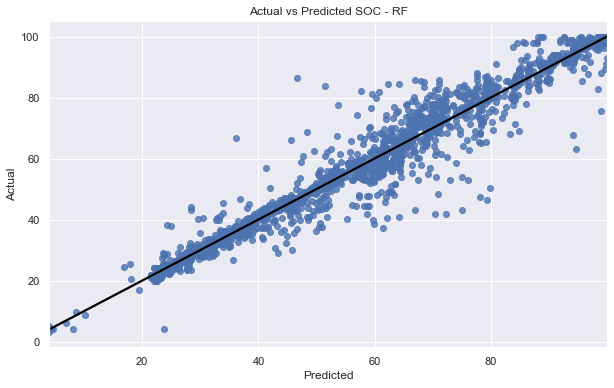

In [19]:
plt.figure(figsize = (10,6))
plt.title('Actual vs Predicted SOC - RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sns.regplot(x = y_pred, y = y_test.values,line_kws={"color": "black"})

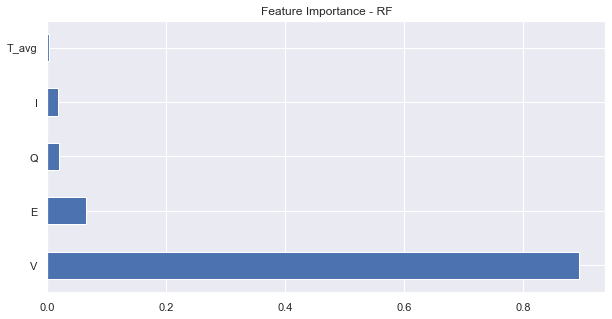

In [20]:
# Feature Importances for the XGB model
feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns[0:len(X.columns)])
feat_importances.nlargest(5).plot(kind ='barh', figsize =(10,5), title ='Feature Importance - RF');

### Future Steps

The implementation above is a basic predictive model based on a single dataset, and has a lot of room for future modification/improvements. Remaining use of life (RUL) and state of health (SOH) can be obtained by analysing the voltage, current and temperature during each charge/discharge cycles.

<hr style="border:2px solid black"> </hr>

Debanjan Guha Neogi | debanjan.guhaneogi@gmail.com